In [20]:
from pepys_import.core.store.data_store import DataStore
import config
import pandas as pd
from sqlalchemy import create_engine
import geopandas as gpd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import hvplot
import hvplot.pandas
import folium

In [21]:
ds = DataStore(
            db_username=config.DB_USERNAME,
            db_password=config.DB_PASSWORD,
            db_host=config.DB_HOST,
            db_port=config.DB_PORT,
            db_name=config.DB_NAME,
            db_type=config.DB_TYPE,
        )

   @@@@ @@@@@        ______                      _                            _   
 @@@@@ @@..@@@@      | ___ \                    (_)                          | |  
  @@@     @@@@@@     | |_/ /__ _ __  _   _ ___   _ _ __ ___  _ __   ___  _ __| |_ 
  @@@     @@@@@@@@   |  __/ _ \ '_ \| | | / __| | | '_ ` _ \| '_ \ / _ \| '__| __|
 @@@@.     @@@@@@@   | | |  __/ |_) | |_| \__ \ | | | | | | | |_) | (_) | |  | |_ 
 @@ #@@ @   ...@@@@@ \_|  \___| .__/ \__, |___/ |_|_| |_| |_| .__/ \___/|_|   \__|
 @@   &        @@@@@            | |     __/ | ______          | |                   
Software Version :  0.0.33



Database Type :  postgres
Database Name :  pepys_solent
Database Host :  localhost
------------------------------------------------------------------------------


In [22]:
engine = create_engine(ds.connection_string, future=False)

## Define functions

In [23]:
def find_within_distance(selected_vessel_sensor_id, distance_threshold=500, time_threshold=1, just_map=False):
    sql = f"""SELECT location, sensor_id::text, time::text from pepys."States"
   WHERE pepys."States".sensor_id = '{selected_vessel_sensor_id}'"""

    selected_vessel = gpd.read_postgis(sql, engine, geom_col="location")
    
    if len(selected_vessel) == 0:
        return "No data"

    sql = f"""WITH selected_vessel AS
      (SELECT * from pepys."States"
       WHERE pepys."States".sensor_id = '{selected_vessel_sensor_id}'),
    non_selected_vessel AS
       (SELECT * from pepys."States"
       WHERE pepys."States".sensor_id != '{selected_vessel_sensor_id}')
    SELECT non_selected_vessel.time::text,
           non_selected_vessel.sensor_id::text,
           non_selected_vessel.location,
           pepys."Sensors".host::text,
           pepys."Platforms".name,
           ST_Distance(non_selected_vessel.location::geography, selected_vessel.location::geography) as dist
    FROM selected_vessel, non_selected_vessel
    LEFT JOIN pepys."Sensors" ON non_selected_vessel.sensor_id = pepys."Sensors".sensor_id
    LEFT JOIN pepys."Platforms" ON pepys."Sensors".host = pepys."Platforms".platform_id
    WHERE
       (selected_vessel.time - non_selected_vessel.time) > '-{time_threshold} minute'::interval
       and (selected_vessel.time - non_selected_vessel.time) < '{time_threshold} minute'::interval
       and ST_DWithin(selected_vessel.location::geography, non_selected_vessel.location::geography, {distance_threshold}); """
    
    close_vessels = gpd.read_postgis(sql, engine, geom_col="location")
    
#     m = folium.Map(control_scale=True)
    m = selected_vessel.explore(tiles='https://tile.openstreetmap.org/{z}/{x}/{y}.png', attr="OSM")
    close_vessels.explore(column='name', m=m, cmap='Set1')
    
    if just_map:
        return m

    close_vessels['time'] = pd.to_datetime(close_vessels['time'])
    selected_vessel['time'] = pd.to_datetime(selected_vessel['time'])
    
    return selected_vessel, close_vessels, m    

In [28]:
def find_within_distance_during_time_range(selected_vessel_sensor_id, distance_threshold=500, time_threshold=1, start_time=None, end_time=None, just_map=False):
    sql = f"""SELECT location, sensor_id::text, time::text from pepys."States"
   WHERE pepys."States".sensor_id = '{selected_vessel_sensor_id}'"""

    selected_vessel = gpd.read_postgis(sql, engine, geom_col="location")
    
    if len(selected_vessel) == 0:
        return "No data"

    sql = f"""WITH selected_vessel AS
      (SELECT * from pepys."States"
       WHERE pepys."States".sensor_id = '{selected_vessel_sensor_id}'),
    non_selected_vessel AS
       (SELECT * from pepys."States"
       WHERE pepys."States".sensor_id != '{selected_vessel_sensor_id}')
    SELECT non_selected_vessel.time::text,
           non_selected_vessel.sensor_id::text,
           non_selected_vessel.location,
           pepys."Sensors".host::text,
           pepys."Platforms".name,
           ST_Distance(non_selected_vessel.location::geography, selected_vessel.location::geography) as dist
    FROM selected_vessel, non_selected_vessel
    LEFT JOIN pepys."Sensors" ON non_selected_vessel.sensor_id = pepys."Sensors".sensor_id
    LEFT JOIN pepys."Platforms" ON pepys."Sensors".host = pepys."Platforms".platform_id
    WHERE
       (selected_vessel.time - non_selected_vessel.time) > '-{time_threshold} minute'::interval
       and (selected_vessel.time - non_selected_vessel.time) < '{time_threshold} minute'::interval
       and ST_DWithin(selected_vessel.location::geography, non_selected_vessel.location::geography, {distance_threshold})
       and selected_vessel.time between '{start_time}' and '{end_time}'"""
    
    close_vessels = gpd.read_postgis(sql, engine, geom_col="location")
    
#     m = folium.Map(control_scale=True)
    m = selected_vessel.explore(tiles='https://tile.openstreetmap.org/{z}/{x}/{y}.png', attr="OSM")
    close_vessels.explore(column='name', m=m, cmap='Set1')
    
    if just_map:
        return m

    close_vessels['time'] = pd.to_datetime(close_vessels['time'])
    selected_vessel['time'] = pd.to_datetime(selected_vessel['time'])
    
    return selected_vessel, close_vessels, m    

In [24]:
def find_within_distance_during_activation(selected_vessel_sensor_id, distance_threshold=500, time_threshold=1, just_map=False):
    sql = f"""SELECT location, sensor_id::text, time::text from pepys."States"
   WHERE pepys."States".sensor_id = '{selected_vessel_sensor_id}'"""

    selected_vessel = gpd.read_postgis(sql, engine, geom_col="location")
    
    if len(selected_vessel) == 0:
        return "No data"

    sql = f"""WITH selected_vessel AS
      (SELECT * from pepys."States"
       WHERE pepys."States".sensor_id = '{selected_vessel_sensor_id}'),
    non_selected_vessel AS
       (SELECT * from pepys."States"
       WHERE pepys."States".sensor_id != '{selected_vessel_sensor_id}')
    SELECT non_selected_vessel.time::text,
           non_selected_vessel.sensor_id::text,
           non_selected_vessel.location,
           pepys."Sensors".host::text,
           pepys."Platforms".name,
           ST_Distance(non_selected_vessel.location::geography, selected_vessel.location::geography) as dist
    FROM selected_vessel, non_selected_vessel
    LEFT JOIN pepys."Sensors" ON non_selected_vessel.sensor_id = pepys."Sensors".sensor_id
    LEFT JOIN pepys."Platforms" ON pepys."Sensors".host = pepys."Platforms".platform_id
    INNER JOIN pepys."Activations" ON non_selected_vessel.time between pepys."Activations".start and pepys."Activations".end
    WHERE
       (selected_vessel.time - non_selected_vessel.time) > '-{time_threshold} minute'::interval
       and (selected_vessel.time - non_selected_vessel.time) < '{time_threshold} minute'::interval
       and ST_DWithin(selected_vessel.location::geography, non_selected_vessel.location::geography, {distance_threshold})
    ORDER BY non_selected_vessel.time"""
    
    close_vessels = gpd.read_postgis(sql, engine, geom_col="location")
    
#     m = folium.Map(control_scale=True)
    m = selected_vessel.explore(tiles='https://tile.openstreetmap.org/{z}/{x}/{y}.png', attr="OSM")
    close_vessels.explore(column='name', m=m, cmap='Set1')
    
    if just_map:
        return m

    close_vessels['time'] = pd.to_datetime(close_vessels['time'])
    selected_vessel['time'] = pd.to_datetime(selected_vessel['time'])
    
    return selected_vessel, close_vessels, m    

## Interactive map showing selected vessel, plus other vessels within 1km of it

In [25]:
# Parameters are selected vessel sensor_id, distance threshold in metres and time threshold in minutes
selected_vessel, close_vessels, m = find_within_distance('5676bde2-1481-47f0-b259-f057009081d3', 1000, 1)
m

## Timeline of close vessels

(16811.33608253704, 16811.778467347223)

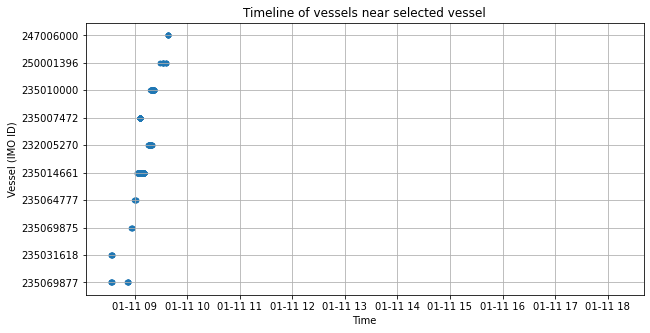

In [7]:
ax = close_vessels.plot.scatter(x='time', y="name", figsize=(10, 5))
# selected_vessel.plot.scatter(x='time', y='sensor_id', ax=ax)
plt.grid()
plt.ylabel("Vessel (IMO ID)")
plt.xlabel("Time")
plt.title("Timeline of vessels near selected vessel")
plt.xlim((16811.33608253704, 16811.778467347223))

## Other statistics of close vessels

In [12]:
close_vessels = close_vessels.set_index(pd.DatetimeIndex(close_vessels.time))

In [13]:
vessels_in_range_by_time = close_vessels.resample('5T').apply(lambda x: len(x.groupby('name').groups))

In [15]:
pd.options.plotting.backend = 'holoviews'

In [17]:
vessels_in_range_by_time.plot(xlabel="Time", ylabel="Number of vessels", title="Number of vessels in range over time")

:Curve   [time]   (0)

In [19]:
close_vessels.dist.hist(xlabel="Distance (m)", ylabel="Frequency", title='Histogram of distance to close vessels')

:Histogram   [dist]   (dist_count)

## Interactive map of vessels within distance during time range

In [29]:
# Parameters are selected vessel sensor_id, distance threshold in metres and time threshold in minutes
selected_vessel, close_vessels, m = find_within_distance_during_time_range('5676bde2-1481-47f0-b259-f057009081d3', 1000, 1, start_time='2016-01-11 09:30:00', end_time='2016-01-12 00:00:00')
m

## Interactive map of vessels within distance during sensor activation periods

This finds all vessels within 1km of the selected vessel during 'Activation periods'. These periods are defined as when a sensor is active in the Activations table. This could be used to narrow down the results to specific time periods when a certain sensor was active (eg. Sonar, Radar, Periscope).

In [8]:
pd.read_sql("""SELECT * from pepys."Activations";""", engine)[['start', 'end']]

,start,end
0,2016-01-11 08:00:00,2016-01-11 08:40:00
1,2016-01-12 12:00:00,2016-01-12 11:00:00


In [9]:
# Parameters are selected vessel sensor_id, distance threshold in metres and time threshold in minutes
selected_vessel, close_vessels, m = find_within_distance_during_activation('5676bde2-1481-47f0-b259-f057009081d3', 1000, 1)
m

In [31]:
m.save("map.html")

In [32]:
!open .